# It's St. Patrick's Day - Let's open up a proper Irish Pub!

**We will definitely need Irish Whiskey - but which should we stock first?**

In this capstone we'll explore the Iowa Liquor Sales dataset to gain insights into Irish Whiskey sales in Iowa. We'll explore dimensionality reduction techniques as well as clustering algorithms to come up with an unsupervised learning model to gain some insight into local sales and help to support a decision as to which Irish whiskies we should have in stock when we open our new pub.

## Data source and context

For this capstone, I used the [Iowa Liquor Sales](https://www.kaggle.com/residentmario/iowa-liquor-sales) publicly data available on kaggle.

**Context:**
The Iowa Department of Commerce requires that every store that sells alcohol in bottled form for off-the-premises consumption must hold a class "E" liquor license (an arrangement typical of most of the state alcohol regulatory bodies). All alcoholic sales made by stores registered thusly with the Iowa Department of Commerce are logged in the Commerce department system, which is in turn published as open data by the State of Iowa.

**Content:**
This dataset contains information on the name, kind, price, quantity, and location of sales of individual containers or packages of containers of alcoholic beverages.

(Side note: I recognize that the Iowa sales data is based on bottle liquor sales and not on-premise consumed liquor sales but it is the best public source of related data available so I'm going to make the assumption that they are comparable for the sake of this exercise.)


## Setup and data import

In [1]:
#Installers:
!pip install umap-learn --quiet
!pip install prince --quiet

In [47]:
#Setup the environment
import numpy as np
import pandas as pd
import seaborn as sns
import scipy
import matplotlib.pyplot as plt
%matplotlib inline

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn import datasets, metrics

import umap
import prince
import time

import warnings
warnings.filterwarnings("ignore")

In [3]:
#Github raw URL to csv file:
rawdata = 'https://raw.githubusercontent.com/wolfy5878/DSI09Capstone3-UnsupervisedLearning/main/IowaLiquorSales_IrishWhiskies.csv'

In [4]:
data = pd.read_csv(rawdata)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87747 entries, 0 to 87746
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Invoice/Item Number    87747 non-null  object 
 1   Date                   87747 non-null  object 
 2   Store Number           87747 non-null  int64  
 3   Store Name             87747 non-null  object 
 4   Address                87747 non-null  object 
 5   City                   87747 non-null  object 
 6   Zip Code               87747 non-null  object 
 7   Store Location         87747 non-null  object 
 8   County Number          87747 non-null  float64
 9   County                 87747 non-null  object 
 10  Category               87747 non-null  float64
 11  Category Name          87747 non-null  object 
 12  Vendor Number          87747 non-null  float64
 13  Vendor Name            87747 non-null  object 
 14  Item Number            87747 non-null  int64  
 15  It

In [5]:
#set system options to show in scrollable windows & with rounding
pd.set_option('display.max_rows', data.shape[0]+1)
pd.set_option('display.max_columns', data.shape[0]+1)
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('use_inf_as_na', True)

## Data Cleaning

In [6]:
#Removing unique ids and unnecessary variables for the scope of our analysis:
data.drop(['Invoice/Item Number', 'Store Number', 'Store Name', 'Address', 
          'Store Location', 'County Number', 'Category',  
           'Vendor Number', 'Item Number','Category Name', 'State Bottle Cost',	'State Bottle Retail', 'Volume Sold (Liters)',	'Volume Sold (Gallons)'], axis = 1, inplace=True)
data.columns

Index(['Date', 'City', 'Zip Code', 'County', 'Vendor Name', 'Item Description',
       'Pack', 'Bottle Volume (ml)', 'Bottles Sold', 'Sale (Dollars)'],
      dtype='object')

In [7]:
#Convert dollar column to float, specifying each char and it's replacement:
data['Sale (Dollars)'] = data['Sale (Dollars)'].replace({'\$': '', ',': ''}, regex=True)
data['Sale (Dollars)'] = data['Sale (Dollars)'].astype(float)

In [8]:
#checking why Zip isn't an int
data['Zip Code'].unique()

array(['52807', '50049', '50314', '50677', '50501', '52544', '51360',
       '52246', '50311', '52761', '52175', '50300', '52208', '51566',
       '50250', '50316', '52732', '52003', '52205', '50701', '50023',
       '52601', '51503', '50613', '50219', '52403', '50322', '52402',
       '50703', '50320', '52317', '50247', '50317', '50131', '51537',
       '50036', '50548', '51105', '50588', '50014', '52501', '50125',
       '52653', '52245', '52060', '52531', '52240', '52101', '50111',
       '50010', '52804', '51035', '50009', '51501', '50021', '51601',
       '51559', '52753', '52627', '52722', '50662', '50273', '51555',
       '50266', '52404', '52411', '50401', '52172', '50265', '50309',
       '50263', '50112', '52405', '50022', '51012', '50461', '52314',
       '50702', '51040', '50630', '52241', '50208', '50595', '51632',
       '52040', '50651', '51104', '51560', '51331', '51351', '50310',
       '52084', '52772', '52001', '52748', '50315', '51241', '50158',
       '50321', '504

In [9]:
#Cleaning up Zip Codes
data.drop(data.loc[data['Zip Code']=='712-2'].index, inplace=True)
data['Zip Code'] = data['Zip Code'].replace({'\.0' : ''},regex = True)
data['Zip Code'] = data['Zip Code'].astype(int)

In [10]:
#Extract Year and Month into separate columns
data['Year'] = pd.DatetimeIndex(data['Date']).year.astype(int)
data['Month'] = pd.DatetimeIndex(data['Date']).month
#Drop date column
data.drop(['Date'], axis = 1, inplace=True)

Checking some of the longer str columns to see if there are any characters that need cleaning up:

In [11]:
cols = ['Vendor Name', 'Item Description', 'County', 'City']
for col in cols:
  print(col, 'values: ',data[col].unique())
  print()

Vendor Name values:  ['Proximo' 'Pernod Ricard USA/Austin Nichols' 'Gemini Spirits'
 'Jim Beam Brands' 'WILLIAM GRANT AND SONS, INC.' 'Castle Brands'
 'Cedar Ridge Vineyards,LLC' 'Aiko Importers Inc' 'Wilson Daniels Ltd.'
 'Palm Bay Imports, Inc.' 'Yahara Bay Distillers, Inc'
 'Moet Hennessy USA, Inc.' 'Diageo Americas' 'Sidney Frank Importing Co.'
 'A Hardy / U.S.A., Ltd.' 'The Wine Group'
 'Prestige Wine and Spirits Group' 'Impex Beverages Inc'
 'Chatham Imports,inc' 'Phillips Beverage Company' 'Bacardi U.S.A., Inc.'
 'Sazerac Co., Inc.' 'Vision Wine and Spirits' 'Luxco-St Louis'
 'Swiss Cellars' 'MHW Ltd' 'WILDMAN AND SONS, F.'
 'Anchor Distilling (PREISS IMPORTS)' 'Classic Wine Imports'
 'REMY COINTREAU USA         .' 'Edrington Group USA LLC'
 'William Grant and Sons, Inc.' 'R�my Cointreau USA' 'Anchor Distilling']

Item Description values:  ['Bushmills Irish Whiskey' 'Jameson Mini' 'Concannon' 'Jameson'
 '2 Gingers' 'Tullamore Dew Irish Whisky' 'Bushmills Irish Honey'
 'Jameson 1

In [12]:
#note that I've handled the replacement of the / character differently for 
# this variable for readability purposes.
data['Item Description'] = data['Item Description'].replace({'\.' : '', 
                                                   '\*' : '', 
                                                   '\'' : '', 
                                                   '\/' : ' ',
                                                   '\,' : '',
                                                   }, 
                                                  regex = True)


In [13]:
data['Vendor Name'] = data['Vendor Name'].replace({'\.' : '', 
                                                   '\*' : '', 
                                                   '\'' : '', 
                                                   '\/' : '', 
                                                   '\,' : '',
                                                   'REMY COINTREAU USA         ' : 'Remy Cointreau USA',
                                                   'R�my Cointreau USA' : 'Remy Cointreau USA' }, 
                                                  regex = True)


In [14]:
data['City'] = data['City'].replace({'\.' : '', 
                                                   '\*' : '', 
                                                   '\'' : '', 
                                                   '\/' : '', 
                                                   '\,' : '',
                                                   }, 
                                                  regex = True)


In [15]:
#Double checking data integrity on text cols:
cols = ['Vendor Name', 'Item Description', 'County', 'City']

for col in cols:
  print(col, 'values: ',data[col].unique())
  print()

Vendor Name values:  ['Proximo' 'Pernod Ricard USAAustin Nichols' 'Gemini Spirits'
 'Jim Beam Brands' 'WILLIAM GRANT AND SONS INC' 'Castle Brands'
 'Cedar Ridge VineyardsLLC' 'Aiko Importers Inc' 'Wilson Daniels Ltd'
 'Palm Bay Imports Inc' 'Yahara Bay Distillers Inc'
 'Moet Hennessy USA Inc' 'Diageo Americas' 'Sidney Frank Importing Co'
 'A Hardy  USA Ltd' 'The Wine Group' 'Prestige Wine and Spirits Group'
 'Impex Beverages Inc' 'Chatham Importsinc' 'Phillips Beverage Company'
 'Bacardi USA Inc' 'Sazerac Co Inc' 'Vision Wine and Spirits'
 'Luxco-St Louis' 'Swiss Cellars' 'MHW Ltd' 'WILDMAN AND SONS F'
 'Anchor Distilling (PREISS IMPORTS)' 'Classic Wine Imports'
 'Remy Cointreau USA' 'Edrington Group USA LLC'
 'William Grant and Sons Inc' 'Anchor Distilling']

Item Description values:  ['Bushmills Irish Whiskey' 'Jameson Mini' 'Concannon' 'Jameson'
 '2 Gingers' 'Tullamore Dew Irish Whisky' 'Bushmills Irish Honey'
 'Jameson 12YR HA' 'Kilbeggan' 'Paddy Devils Apple Mini'
 'Jameson Black 

In [16]:
#drop any NAs that might be in the dataset:
data.dropna(inplace=True)

## EDA

In [17]:
#After cleaning let's see what we have:
data.info()
print()
data.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 87688 entries, 0 to 87746
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   City                87688 non-null  object 
 1   Zip Code            87688 non-null  int32  
 2   County              87688 non-null  object 
 3   Vendor Name         87688 non-null  object 
 4   Item Description    87688 non-null  object 
 5   Pack                87688 non-null  int64  
 6   Bottle Volume (ml)  87688 non-null  int64  
 7   Bottles Sold        87688 non-null  int64  
 8   Sale (Dollars)      87688 non-null  float64
 9   Year                87688 non-null  int64  
 10  Month               87688 non-null  int64  
dtypes: float64(1), int32(1), int64(5), object(4)
memory usage: 7.7+ MB



,City,Zip Code,County,Vendor Name,Item Description,Pack,Bottle Volume (ml),Bottles Sold,Sale (Dollars),Year,Month
0,DAVENPORT,52807,Scott,Proximo,Bushmills Irish Whiskey,12,750,4,78.00,2014,2
1,CHARITON,50049,Lucas,Pernod Ricard USAAustin Nichols,Jameson Mini,10,600,1,17.82,2015,7
2,DES MOINES,50314,Polk,Proximo,Bushmills Irish Whiskey,12,1000,2,48.76,2015,9
3,WAVERLY,50677,Bremer,Gemini Spirits,Concannon,6,750,6,90.00,2013,5
4,FORT DODGE,50501,Webster,Pernod Ricard USAAustin Nichols,Jameson,24,375,24,242.64,2014,12


In [18]:
#Checking out descriptive stats:
data.describe()

,Zip Code,Pack,Bottle Volume (ml),Bottles Sold,Sale (Dollars),Year,Month
count,87688.00,87688.00,87688.00,87688.00,87688.00,87688.00,87688.00
mean,51268.24,12.27,832.13,8.47,207.50,2014.06,6.36
std,1001.57,4.39,399.54,26.84,697.80,1.35,3.50
min,50002.00,1.00,50.00,1.00,5.94,2012.00,1.00
25%,50314.00,12.00,750.00,2.00,40.44,2013.00,3.00
50%,51103.00,12.00,750.00,3.00,77.96,2014.00,6.00
75%,52302.00,12.00,1000.00,12.00,251.88,2015.00,9.00
max,56201.00,24.00,4800.00,1800.00,48582.00,2016.00,12.00


In [19]:
data.describe(include='O')

,City,County,Vendor Name,Item Description
count,87688,87688,87688,87688
unique,567,98,33,124
top,DES MOINES,Polk,Pernod Ricard USAAustin Nichols,Jameson
freq,7670,18685,66022,51958


<AxesSubplot:>

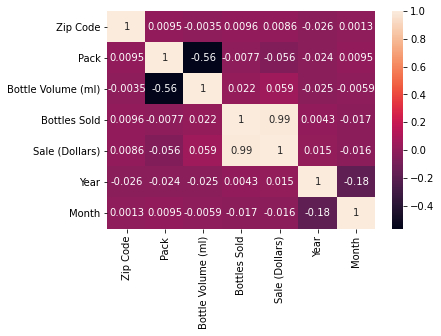

In [20]:
#Checking correlation between numeric variables:
sns.heatmap(data.corr(), annot = True)

Index(['Zip Code', 'Pack', 'Bottle Volume (ml)', 'Bottles Sold',
       'Sale (Dollars)', 'Year', 'Month'],
      dtype='object')


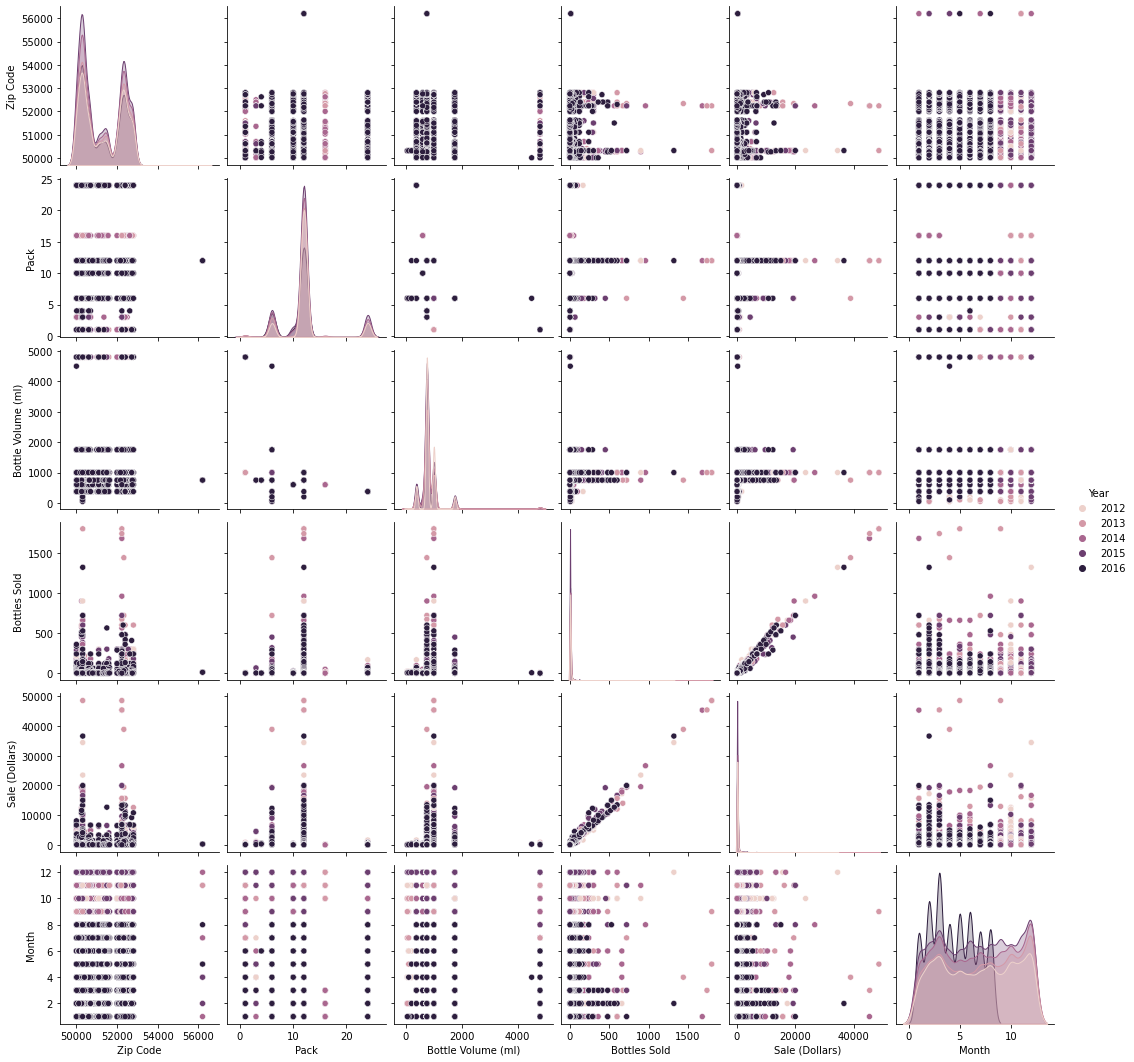

In [21]:
#Looking closer at the relationships between numeric data variables, by year:
num_data = data.select_dtypes(include="number")
print(num_data.columns)
sns.pairplot(data=num_data,hue='Year')
plt.show()

Not surprised that Pack and Bottle Volume are correlated as well as Bottle Sold and Sale (Dollars). There is hardly any correlation worth mentioning between any of the other variables.

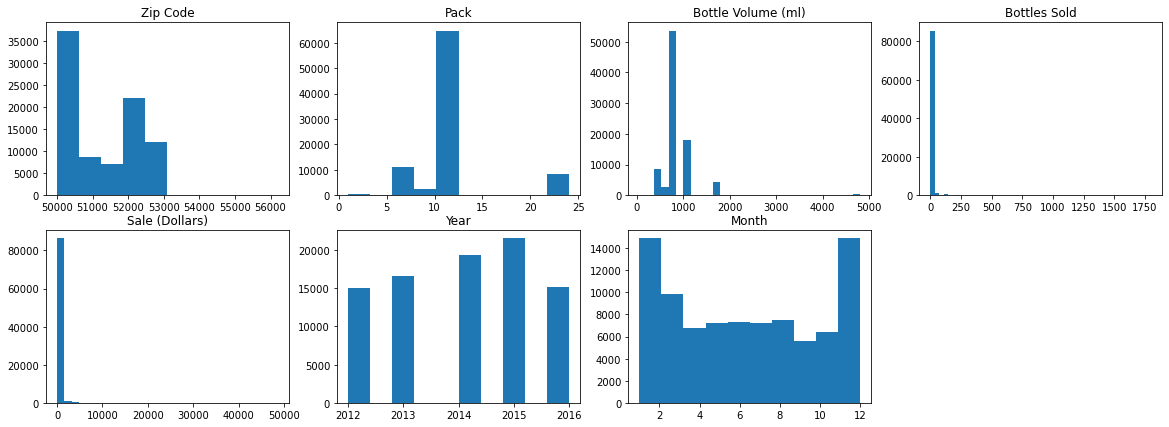

In [22]:
#Checking distribution of numeric variables:
# Histograms:
plt.figure(figsize = (20,7)) # wide, tall
plt.subplots_adjust(wspace=0.2)
plt.subplots_adjust(hspace=0.2)

plt.subplot(2,4,1)  # num rows, num col, index
plt.hist(data['Zip Code'])
plt.title("Zip Code")

plt.subplot(2,4,2)  # num rows, num col, index
plt.hist(data['Pack'])
plt.title("Pack")

plt.subplot(2,4,3)  # num rows, num col, index
plt.hist(data['Bottle Volume (ml)'], bins=30)
plt.title("Bottle Volume (ml)")

plt.subplot(2,4,4)  # num rows, num col, index
plt.hist(data['Bottles Sold'], bins=50)
plt.title("Bottles Sold")

plt.subplot(2,4,5)  # num rows, num col, index
plt.hist(data['Sale (Dollars)'], bins=30)
plt.title("Sale (Dollars)")

plt.subplot(2,4,6)  # num rows, num col, index
plt.hist(data['Year'])
plt.title("Year")

plt.subplot(2,4,7)  # num rows, num col, index
plt.hist(data['Month'])
plt.title("Month")

plt.show()

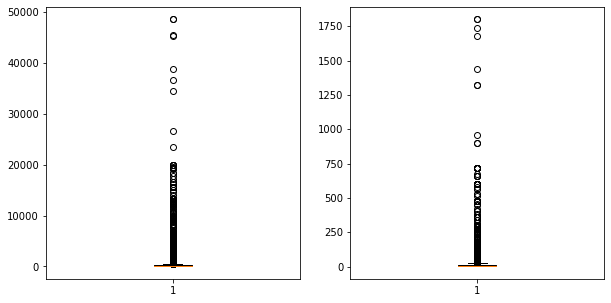

In [23]:
plt.figure(figsize = (10,5)) # wide, tall
plt.subplot(121)
plt.boxplot(data['Sale (Dollars)'])
plt.subplot(122)
plt.boxplot(data['Bottles Sold'])
plt.show()

While some of these variables could be considered categorical rather than continuous, clearly none of them are normally distributed nor are they similarly scaled.

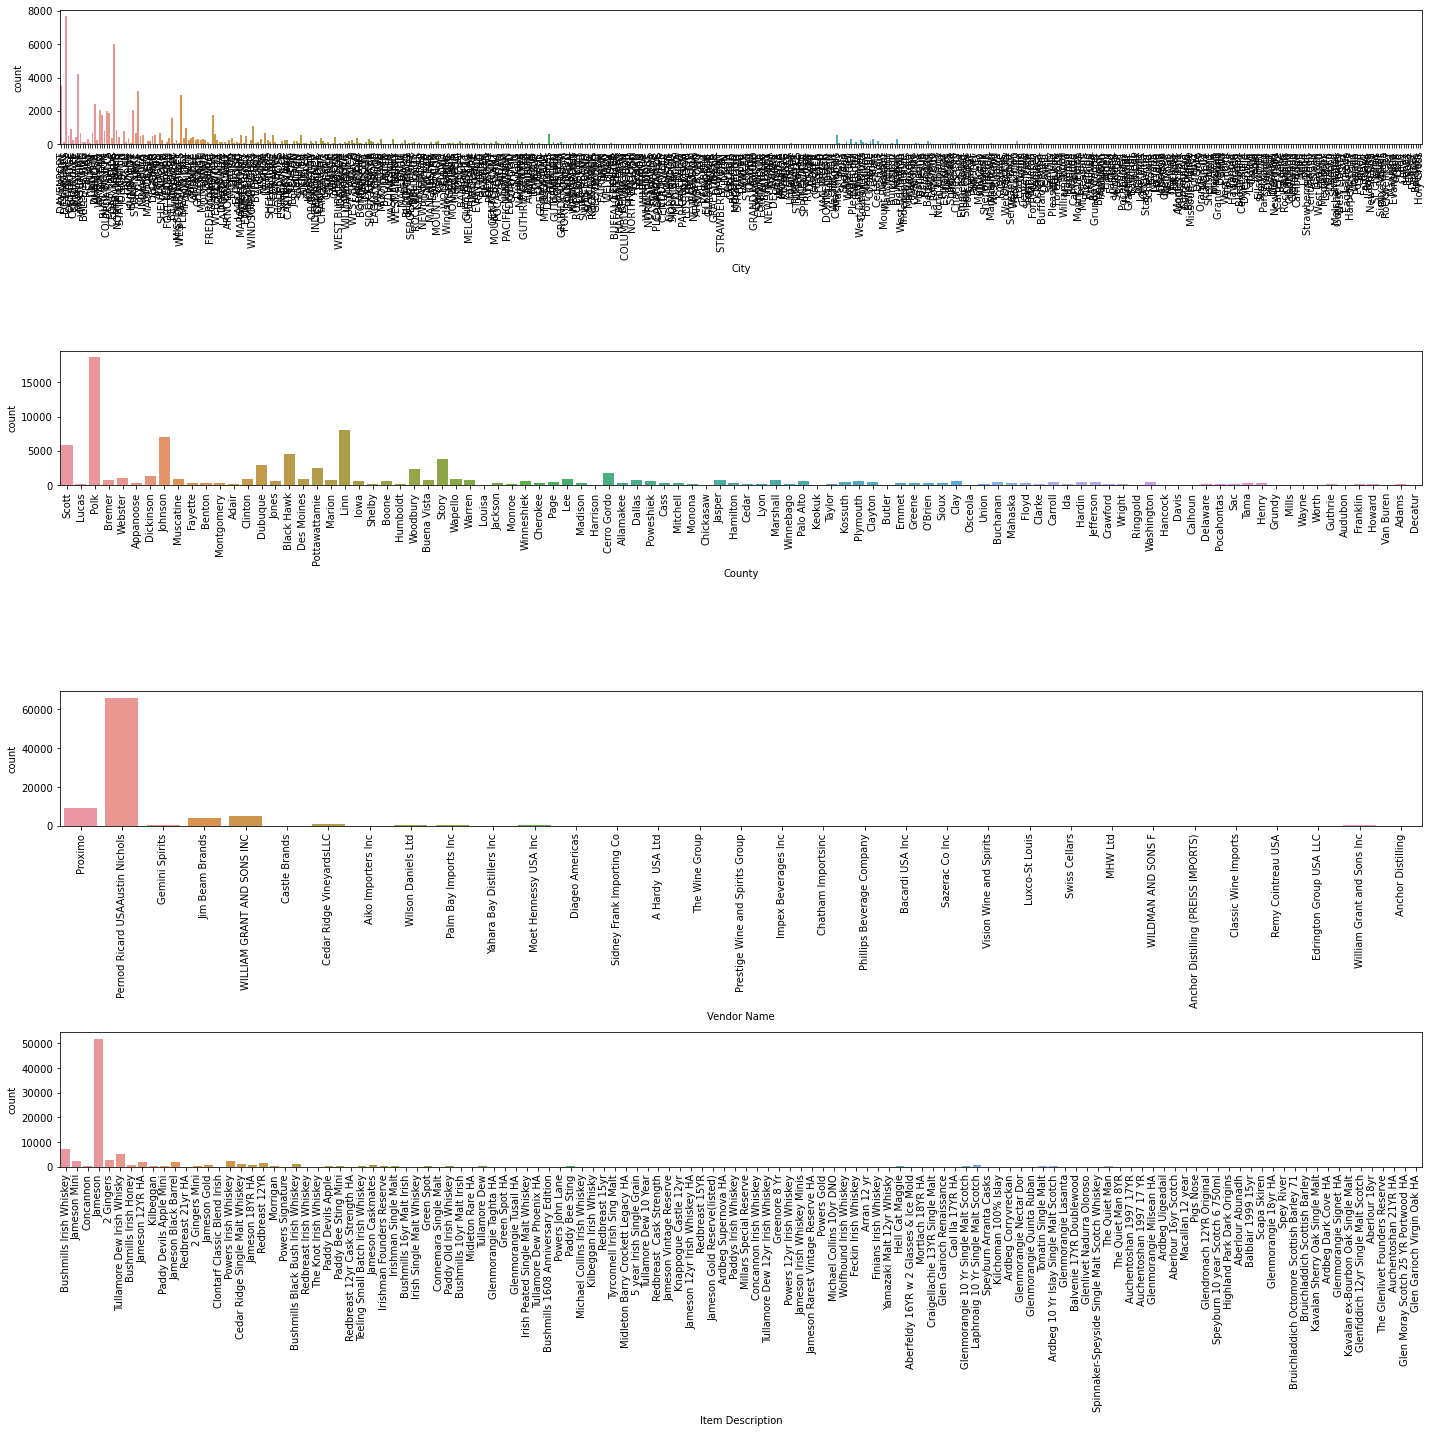

In [24]:
#Checking the frequency counts on the non-numeric variables:

plt.figure(figsize = (20,20))

plt.subplot(4,1,1)
sns.countplot(x="City", data=data)
plt.xticks(rotation=90)

plt.subplot(4,1,2)
sns.countplot(x="County", data=data)
plt.xticks(rotation=90)

plt.subplot(4,1,3)
sns.countplot(x="Vendor Name", data=data)
plt.xticks(rotation=90)

plt.subplot(4,1,4)
sns.countplot(x="Item Description", data=data)
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

## Dimension Reduction

### FAMD

FAMD works best when there are relatively few categorical variables compared to numeric ones, we have a good balance of categorical and numeric variables so we'll work with them as they are.

In [25]:
#Copying df for this dim reduction to keep it separate from the base dataframe.
df1 = data.copy()

In [26]:
#Creating the algorithm, then fitting and transforming the data to it
famd = prince.FAMD(n_components=829)
df_famd = famd.fit_transform(df1)
df_famd.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 87688 entries, 0 to 87746
Columns: 829 entries, 0 to 828
dtypes: float64(829)
memory usage: 557.8 MB


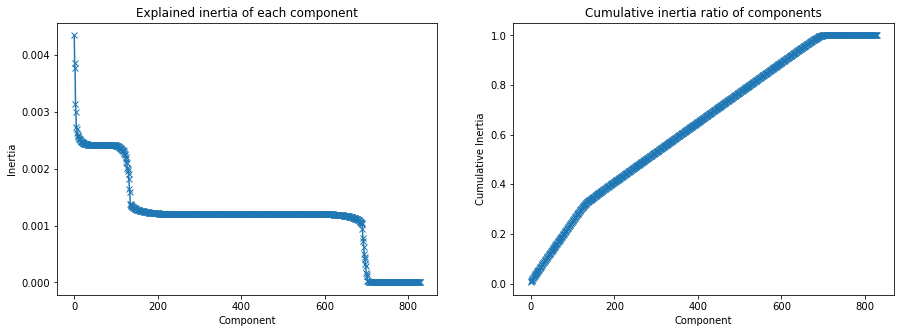

In [27]:
#Checking to see how much of the inertia is explained by the number of the components:
plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.plot(range(0, famd.n_components), famd.explained_inertia_, "x-")
plt.xlabel("Component")
plt.ylabel("Inertia")
plt.title("Explained inertia of each component")
plt.subplot(122)
plt.plot(range(0, famd.n_components), np.cumsum(famd.explained_inertia_), "x-")
plt.xlabel("Component")
plt.ylabel("Cumulative Inertia")
plt.title("Cumulative inertia ratio of components")
plt.show()

It looks like there are a couple of drop off points that make sense to cover the explained inertia.

It could make sense to pick:
 - around 150 where the first bend shows an indication of starting to diminish in returns
 - around 80% of the explained inertia, with about 550 components)
 - around 750 for 100% and where the second bend is, but then this wouldn't really reduce our dimensions very much

For the FAMD output, I'm going to use 150 components and see what the clustering models look like with this.

In [28]:
#Updating the FAMD algorithm for 150 components, then fitting the data to it:
famd = prince.FAMD(n_components=150)
df_famd = famd.fit_transform(df1)
df_famd.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 87688 entries, 0 to 87746
Columns: 150 entries, 0 to 149
dtypes: float64(150)
memory usage: 103.5 MB


### PCA

I'm also going to focus on the just numeric variables with PCA and see what the clustering models look like with just this. PCA is actually a part of FAMD calculations, but with the numeric variables centering around both location and sales/volume data, it would be interesting if using this technique yields different results in the clustering models.

Before applying PCA, we should always mean normalize our variables and scale the data. Note that standardizing the variables also includes mean normalization, so if we standardize our variables we don't need to mean normalize beforehand.

In [71]:
#Isolate the numeric variables into a df for PCA:
df2 = num_data #data.select_dtypes(include=['int64','float64'])
df2.head()

,Zip Code,Pack,Bottle Volume (ml),Bottles Sold,Sale (Dollars),Year,Month
0,52807,12,750,4,78.00,2014,2
1,50049,10,600,1,17.82,2015,7
2,50314,12,1000,2,48.76,2015,9
3,50677,6,750,6,90.00,2013,5
4,50501,24,375,24,242.64,2014,12


In [72]:
#standardize the data:
scaler = StandardScaler()
df2_scaled = scaler.fit_transform(df2)

In [73]:
#Creating the PCA algorithm and fiting/transforming the data to it
pca = PCA(n_components=7)
df_pca = pca.fit_transform(df2_scaled)

In [77]:
type(df_pca)

numpy.ndarray

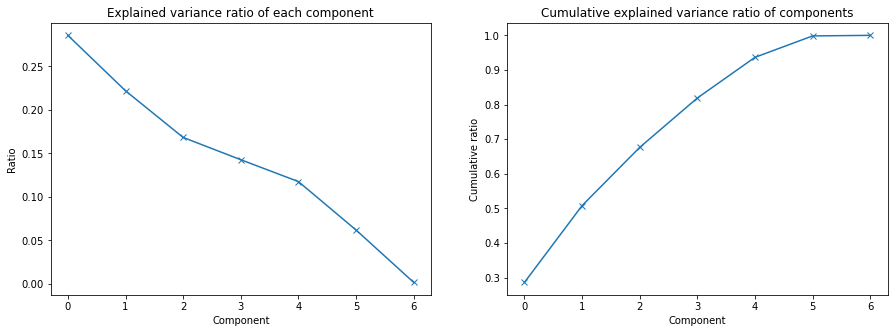

In [32]:
#Let's see how much of the variance is explained by each component
plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.plot(range(0, pca.n_components_), pca.explained_variance_ratio_, "x-")
plt.xlabel("Component")
plt.ylabel("Ratio")
plt.title("Explained variance ratio of each component")
plt.subplot(122)
plt.plot(range(0, pca.n_components_), np.cumsum(pca.explained_variance_ratio_), "x-")
plt.xlabel("Component")
plt.ylabel("Cumulative ratio")
plt.title("Cumulative explained variance ratio of components")
plt.show()

There are a couple of options I can look at here for number of components to account for the explained variance:
 - 2 components is the default, and would explain about 70% of the variance - not too bad
 - 5 components would explain 100%, but wouldn't really reduce the total number of components by much from the original set
 
I'm going to stick with the default of 2.

In [78]:
#Updating the PCA algorithm to 2 components then fitting the data to it:
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df2_scaled)

## Clustering - KMeans

### How many clusters?

First let's look at what a good number of cluster will be for k-means but with the different outputs from the clustering algorithms above - FAMD and PCA.

In [34]:
#With FAMD components:
inertias = []
sils = []
cluster_range = range(2,1001,100)

for cluster in cluster_range:
    kmeans = KMeans(n_clusters=cluster)
    full_pred = kmeans.fit_predict(df_famd)
    inertias.append(kmeans.inertia_)
    sils.append(metrics.silhouette_score(df_famd, full_pred, metric="euclidean"))

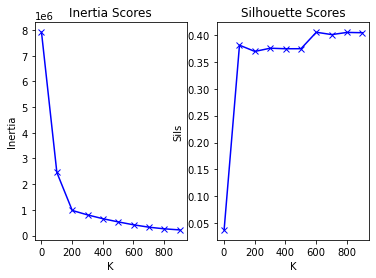

In [35]:
plt.subplot(121)
plt.plot(cluster_range, inertias, "bx-")
plt.xlabel("K")
plt.ylabel("Inertia")
plt.title("Inertia Scores")

plt.subplot(122)
plt.plot(cluster_range, sils, "bx-")
plt.xlabel("K")

plt.ylabel("Sils")
plt.title("Silhouette Scores")
plt.show()

Looks like if I'm using the FAMD components, then 200 is a good number of clusers.

In [36]:
#Resetting the k-means model with FAMD components to 200 clusters:
famd_km_cluster = KMeans(n_clusters=200, random_state=42)
#leave at default max_iteration as default (300) unless it's not converging, then up it.

In [37]:
%timeit famd_km_cluster.fit(df_famd)
famd_km_y_pred = famd_km_cluster.predict(df_famd)
print()
print("The silhouette score of the k-Means solution: {}"
      .format(metrics.silhouette_score(df_famd, famd_km_y_pred, metric='euclidean')))

1min 5s ± 943 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

The silhouette score of the k-Means solution: 0.37024487311172616


In [38]:
print('FAMD K-Means prediction object shape: ',famd_km_y_pred.shape)
print('FAMD component object shape: ', df_famd.shape)
df_famd.head()

FAMD K-Means prediction object shape:  (87688,)
FAMD component object shape:  (87688, 150)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149
0,-1.72,-0.58,-0.79,1.18,-0.79,-0.31,1.60,-0.35,1.03,0.14,-0.37,0.20,0.15,-0.42,-0.02,0.43,0.11,0.33,0.16,0.96,-0.21,0.27,0.11,-0.04,-0.28,-0.34,-0.14,0.34,0.21,-0.05,-0.04,-0.05,-0.08,0.12,-0.02,-0.13,0.05,-0.00,0.10,0.19,0.05,-0.03,0.21,-0.26,0.01,-0.21,-0.12,-0.05,0.10,0.25,0.03,0.31,-0.02,0.14,0.06,-0.01,-0.04,-0.32,-0.08,0.10,-0.04,-0.05,-0.24,0.06,0.03,-0.29,0.02,-0.17,-0.02,0.18,-0.26,-0.25,-0.22,-0.10,-0.42,-0.08,0.36,-0.08,-0.25,0.02,0.01,0.06,0.22,-0.05,-0.00,0.05,-0.20,-0.24,0.14,0.04,-0.01,0.05,-0.08,-0.15,0.13,-0.21,-0.07,0.19,0.30,-0.11,-0.14,-0.33,0.46,-0.15,-0.50,-0.07,-0.25,0.00,0.16,-0.32,0.48,0.26,0.61,0.31,0.32,-0.44,-0.38,-0.11,0.06,0.01,-0.38,0.24,-0.05,0.49,0.11,0.07,0.10,-0.31,-0.42,0.26,-0.26,-0.55,0.05,-0.05,-0.08,0.10,-0.06,0.11,-0.01,-0.15,0.18,0.11,-0.07,-0.09,0.04,0.03,0.02,-0.09,0.00,0.12
1,1.21,-0.50,0.29,-0.05,-0.06,-0.10,-0.90,-0.49,0.40,-0.42,-0.06,0.41,0.59,0.21,0.66,0.04,-1.20,-0.86,-0.46,0.43,0.12,-1.29,2.50,-0.68,1.40,-4.27,4.20,-1.17,-0.34,1.65,-1.72,-0.42,-1.98,-2.87,-0.56,-2.47,-2.88,-2.42,-1.12,6.55,-2.92,-1.07,-2.87,-4.30,1.01,-4.63,-6.74,-1.05,0.75,-1.39,-5.06,2.15,-2.66,1.80,-0.43,2.11,-1.51,3.72,-1.83,-1.09,-0.33,0.10,3.40,3.38,-0.89,-4.24,1.28,1.79,-0.33,-0.59,1.19,1.20,3.43,0.80,-0.42,-1.59,-2.33,1.41,-0.83,0.15,2.12,2.34,2.19,0.95,-1.13,0.13,2.06,-3.78,-2.33,-2.10,0.10,-2.75,2.23,-2.21,1.59,1.24,-0.47,-1.74,-1.14,-0.82,-0.20,-0.13,0.36,-1.28,-0.20,2.42,1.22,0.72,-0.87,-0.60,-1.29,0.06,0.79,1.77,-2.62,0.63,1.96,-0.65,-1.39,1.54,-0.22,1.34,-0.33,0.32,1.20,1.75,0.32,0.48,-0.54,-1.18,0.21,0.31,0.50,0.29,-0.19,-0.40,-0.03,0.01,0.01,-0.22,0.01,-0.24,0.14,-0.15,0.06,-0.12,-0.13,-0.11,-0.03,-0.17
2,1.08,-0.32,-0.67,1.26,-1.08,0.07,0.99,-0.99,0.10,0.15,0.13,-0.14,0.21,-0.18,0.30,-0.03,0.14,-0.05,0.14,-0.08,0.00,0.04,0.04,-0.02,0.06,0.04,0.07,0.02,0.03,-0.02,-0.01,0.01,-0.01,-0.01,-0.04,0.05,0.03,0.08,0.06,-0.01,-0.06,0.00,0.00,-0.03,0.00,-0.00,0.05,0.01,0.05,-0.01,-0.07,0.01,0.03,0.01,0.02,0.04,0.06,-0.12,0.12,-0.04,0.05,0.02,-0.02,0.09,0.13,0.05,-0.06,-0.13,0.07,0.03,0.09,-0.12,-0.07,0.12,-0.01,-0.01,-0.09,0.00,-0.14,0.07,-0.02,0.05,0.02,0.28,-0.17,-0.07,0.13,-0.01,0.11,0.06,-0.07,-0.06,0.19,-0.07,-0.03,-0.32,0.11,0.43,0.21,-0.12,-0.13,-0.28,0.15,-0.00,0.20,-0.26,0.12,0.12,0.21,0.02,0.15,0.29,0.35,-0.11,0.09,-0.42,-0.02,0.22,-0.13,0.09,-0.29,0.19,0.22,-0.15,0.41,0.02,-0.02,-0.26,-0.50,-0.11,-0.02,0.04,-0.34,0.01,0.22,0.04,-0.00,0.08,0.01,0.12,0.07,-0.06,0.12,0.01,0.11,0.04,0.08,0.02,0.09,-0.08
3,0.73,-0.26,-1.93,1.12,-1.01,4.51,-1.61,2.56,-1.81,1.48,-6.69,2.69,-1.70,-1.66,-4.89,-0.73,1.51,-0.06,3.56,-2.15,-1.76,0.01,-1.40,-1.58,-3.97,-1.55,-0.18,0.38,-0.52,1.05,-1.29,1.66,0.89,-0.84,-0.67,1.70,0.03,0.09,0.01,-0.36,-0.66,-0.64,-0.26,-0.97,-0.18,0.01,-0.06,-0.62,-0.53,0.35,-0.43,0.81,0.06,-0.07,-0.26,0.97,-0.28,0.63,0.78,-1.54,1.11,0.36,-0.77,-0.10,-0.23,0.86,2.39,1.97,-0.35,0.27,1.01,-0.67,1.37,-1.31,-0.62,0.77,-0.54,-0.97,-0.01,-1.36,-0.08,-0.12,-1.00,-0.90,-0.22,-1.99,0.71,0.63,-0.29,1.40,1.25,-1.10,-0.21,0.26,1.11,0.47,0.99,-3.45,-0.63,-1.20,0.24,-1.14,-0.12,2.75,0.36,1.35,0.80,1.12,0.55,0.70,-0.45,0.59,1.92,0.44,3.69,0.73,-1.12,3.41,1.95,0.83,0.92,0.40,-0.52,2.13,0.68,0.02,-0.85,0.48,0.35,-0.29,0.16,0.26,-0.62,-0.07,0.13,-0.41,-0.09,-0.07,-0.07,0.11,-0.02,0.09,0.24,-0.17,0.29,0.19,-0.05,-0.03,-0.15,0.06
4,0.62,-0.32,1.97,-0.20,-0.23,0.20,0.12,0.46,-0.44,-0.53,0.58,0.05,0.29,-1.05,0.05,0.42,-0.01,1.41,-0.60,1.56,-1.45,-0.13,-0.91,0.12,-0.51,1.04,0.32,-0.47,-0.57,0.57,0.46,-0.26,-0.04,-0.03,0.78,0.74,-0

In [39]:
#With PCA Components:
inertias = []
sils = []
cluster_range = range(2,41,2)

for cluster in cluster_range:
    kmeans = KMeans(n_clusters=cluster)
    full_pred = kmeans.fit_predict(df_pca)
    inertias.append(kmeans.inertia_)
    sils.append(metrics.silhouette_score(df_pca, full_pred, metric="euclidean"))

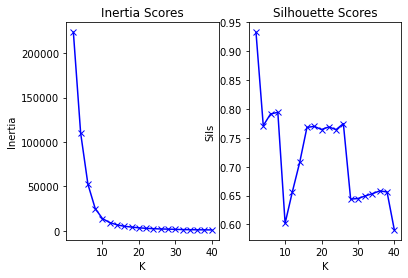

In [40]:
plt.subplot(121)
plt.plot(cluster_range, inertias, "bx-")
plt.xlabel("K")
plt.ylabel("Inertia")
plt.title("Inertia Scores")

plt.subplot(122)
plt.plot(cluster_range, sils, "bx-")
plt.xlabel("K")

plt.ylabel("Sils")
plt.title("Silhouette Scores")
plt.show()

It looks like for the PCA components, 2 is the best number of clusters.

In [41]:
#Resetting the k-means model with PCA components to 2 clusters:
pca_km_cluster = KMeans(n_clusters=2, random_state=42)
#leave at default max_iteration unless it's not converging, then up it.

In [42]:
%timeit pca_km_cluster.fit(df_pca)
pca_km_y_pred = pca_km_cluster.predict(df_pca)
print()
print("The silhouette score of the k-Means solution: {}"
      .format(metrics.silhouette_score(df_pca, pca_km_y_pred, metric='euclidean')))

306 ms ± 5.16 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

The silhouette score of the k-Means solution: 0.9329929710522759


Let's take a quick peek at how consistently the pca model predicts the clusters using our chosen number of clusters (2) and then a few more near that in number. 

First, we're going to split the data into 2 equal parts and then run train_test_split on each half to see how the clusters look.

In [43]:
# Split the PCA data into four equally-sized samples. First we break it in half:
X_half1, X_half2, X_pcahalf1, X_pcahalf2 = train_test_split(
    df2_scaled,
    df_pca,
    test_size=0.5,
    random_state=42)

In [44]:
# Data frame to store features and predicted cluster memberships.
ypred = pd.DataFrame()

# Pass a list of tuples and a counter that increments each time we go
# through the loop. The tuples are the data to be used by k-means,
# and the PCA-derived features for graphing. We use k-means to fit a
# model to the data, then store the predicted values and the two-feature
# PCA solution in the data frame.
for counter, kdata in enumerate([
    (X_half1, X_pcahalf1),
    (X_half2, X_pcahalf2)]):
    
    # Put the features into ypred.
    ypred['pcahalf1' + '_sample' + str(counter)] = kdata[1][:, 0]
    ypred['pcahalf2' + '_sample' + str(counter)] = kdata[1][:, 1]
    
    # Generate cluster predictions and store them for clusters 2 to 4.
    for nclust in range(2,6):
        pred = KMeans(n_clusters=nclust, random_state=42).fit_predict(kdata[counter])
        ypred['clust' + str(nclust) + '_sample' + str(counter)] = pred

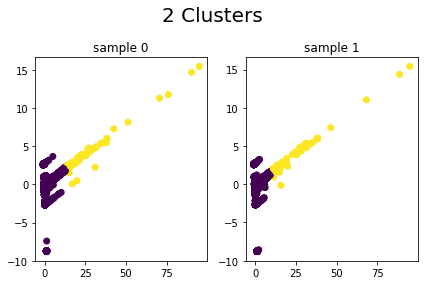

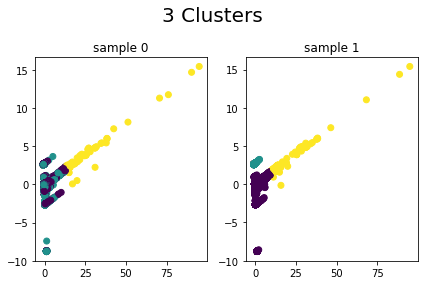

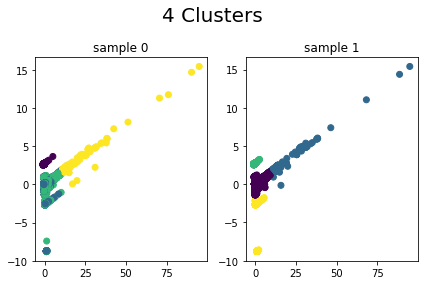

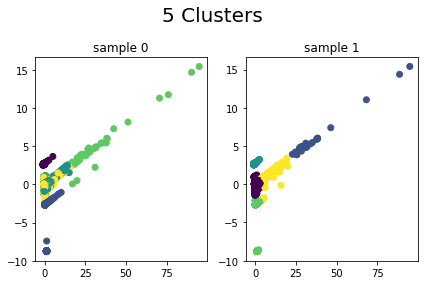

In [45]:
# For each  number of clusters, plot the clusters using the
# pca features for each sample.
for cluster in range(2,6):
    
    # Make a grid of subplots.
    f, axarr = plt.subplots(1, 2)
    
    # Make a plot for each sample.
    for i in range(2):
        
        # PCA-created features.
        x_sub = ypred['pcahalf1_sample{}'.format(i)]
        y_sub = ypred['pcahalf2_sample{}'.format(i)]
        
        # Cluster assignments.
        c = ypred['clust{}_sample{}'.format(cluster, i)]
        
        # Assign the subplot to its place on the grid.
        axarr[i].scatter(x_sub, y_sub, c=c)
        axarr[i].set_title('sample {}'.format(i))
    
    # Space out the plots so that the headings don't overlap axis values.
    plt.suptitle('{} Clusters'.format(cluster), fontsize=20)
    plt.tight_layout()
    plt.show()
    print('\n')

As a visual test, you can see that the 2 cluster model seems to be more consistent in predicting the outcomes than 3, 4, and 5 clusters. We will continue with two clusters for PCA and see how it looks for our conclusion.

## Clustering DBSCAN
### How many clusters?

In [48]:
#Setup the DBSCAN model
pca_dbscan_cluster = DBSCAN(eps=1, min_samples=5)

In [86]:
data.head()

,City,Zip Code,County,Vendor Name,Item Description,Pack,Bottle Volume (ml),Bottles Sold,Sale (Dollars),Year,Month
0,DAVENPORT,52807,Scott,Proximo,Bushmills Irish Whiskey,12,750,4,78.00,2014,2
1,CHARITON,50049,Lucas,Pernod Ricard USAAustin Nichols,Jameson Mini,10,600,1,17.82,2015,7
2,DES MOINES,50314,Polk,Proximo,Bushmills Irish Whiskey,12,1000,2,48.76,2015,9
3,WAVERLY,50677,Bremer,Gemini Spirits,Concannon,6,750,6,90.00,2013,5
4,FORT DODGE,50501,Webster,Pernod Ricard USAAustin Nichols,Jameson,24,375,24,242.64,2014,12


In [88]:
#Create temp df:
X_pca_df = pd.get_dummies(data['Item Description'], drop_first=True, dtype='int64')
X_pca_df['pca0'] = df_pca[:,0]
X_pca_df['pca1'] = df_pca[:,1]
X_pca_df.head()

,2 Gingers Mini,5 year Irish Single Grain,Aberfeldy 16YR w 2 Glasses & Ice Mold,Aberlour 16yr Scotch,Aberlour 18yr,Aberlour Abunadh,Ardbeg 10 Yr Islay Single Malt Scotch,Ardbeg Corryvreckan,Ardbeg Dark Cove HA,Ardbeg Supernova HA,Ardbeg Uigeadail,Arran 12 yr,Auchentoshan 1997 17 YR,Auchentoshan 1997 17YR,Auchentoshan 21YR HA,Balblair 1999 15yr,Balvenie 17YR Doublewood,Bruichladdich Octomore Scottish Barley 71,Bruichladdich Scottish Barley,Bushmills 10yr Malt Irish,Bushmills 1608 Anniversary Edition,Bushmills 16yr Malt Irish,Bushmills Black Bush Irish Whiskey,Bushmills Irish Honey,Bushmills Irish Whiskey,Caol Ila 17YR HA,Cedar Ridge Single Malt Whiskey,Clontarf Classic Blend Irish,Concannon,Concannon Irish Whiskey,Connemara Single Malt,Craigellachie 13YR Single Malt,Feckin Irish Whiskey,Finians Irish Whiskey,Glen Garioch Renaissance,Glen Garioch Virgin Oak HA,Glen Moray Scotch 25 YR Portwood HA,Glendronach 12YR Original,Glenfiddich 12yr Single Malt Scotch,Glenlivet Nadurra Oloroso,Glenmorangie 10 Yr Single Malt Scotch,Glenmorangie 18yr HA,Glenmorangie Lasanta,Glenmorangie Milsean HA,Glenmorangie Nectar Dor,Glenmorangie Quinta Ruban,Glenmorangie Signet HA,Glenmorangie Taghta HA,Glenmorangie Tusail HA,Green Spot,Green Spot HA,Greenore 8 Yr,Hell Cat Maggie,Highland Park Dark Origins,Irish Peated Single Malt Whiskey,Irish Single Malt Whiskey,Irishman Founders Reserve,Irishman Single Malt,Jameson,Jameson 12YR HA,Jameson 12yr Irish Whiskey HA,Jameson 18YR HA,Jameson Black Barrel,Jameson Caskmates,Jameson Gold,Jameson Gold Reserve(listed),Jameson Irish Whiskey Minis,Jameson Mini,Jameson Rarest Vintage Reserve HA,Jameson Vintage Reserve,Kavalan Sherry Oak Single Malt,Kavalan ex-Bourbon Oak Single Malt,Kilbeggan,Kilbeggan Irish Whisky,Kilchoman 100% Islay,Knappogue Castle 12yr,Laphroaig 10 Yr Single Malt Scotch,Macallan 12 year,Michael Collins 10yr DNO,Michael Collins Irish Whiskey,Midleton Barry Crockett Legacy HA,Midleton Rare HA,Millars Special Reserve,Morrigan,Mortlach 18YR HA,Paddy Bee Sting,Paddy Bee Sting Mini,Paddy Devils Apple,Paddy Devils Apple Mini,Paddy Old Irish Whiskey,Paddys Irish Whiskey,Pigs Nose,Powers 12yr Irish Whiskey,Powers Gold,Powers Irish Whiskey,Powers John Lane,Powers Signature,Redbreast Cask Strength,Redbreast 12YR,Redbreast 12yr Cask Strength HA,Redbreast 15YR,Redbreast 15yr,Redbreast 21yr HA,Redbreast Irish Whiskey,Scapa Skiren,Spey River,Speyburn 10 year Scotch 6 750ml,Speyburn Arranta Casks,Spinnaker-Speyside Single Malt Scotch Whiskey,Teeling Small Batch Irish Whiskey,The Glenlivet Founders Reserve,The Knot Irish Whiskey,The Quiet Man,The Quiet Man 8YR,Tomatin Single Malt,Tullamore Dew,Tullamore Dew 10 Year,Tullamore Dew 12yr Irish Whiskey,Tullamore Dew Irish Whisky,Tullamore Dew Phoenix HA,Tyrconnell Irish Sing Malt,Wolfhound Irish Whiskey,Yamazaki Malt 12yr Whisky,pca0,pca1
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-0.21,0.07
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-0.40,-0.04
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-0.29,-0.40
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-0.06,-0.90
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [90]:
#fit the model to the transformed pca data
pca_clusters = pca_dbscan_cluster.fit_predict(X_pca_df)

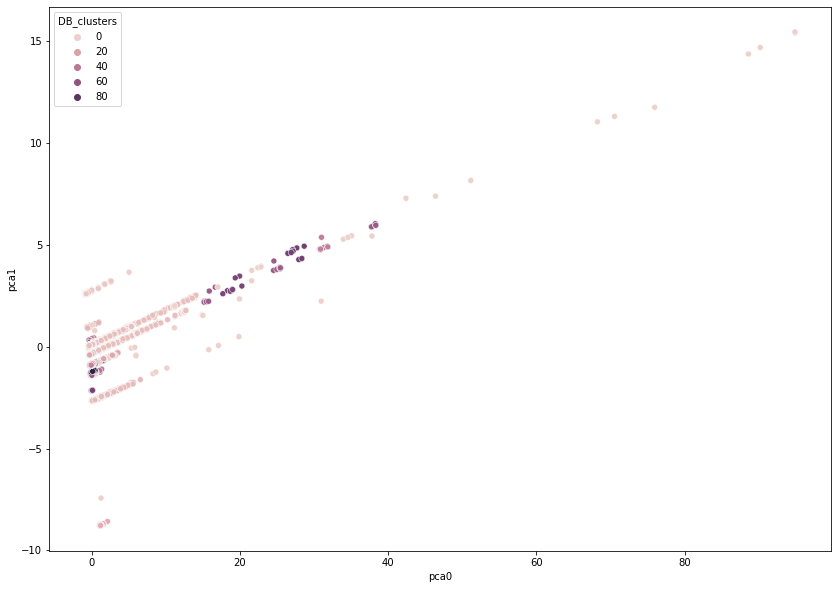

In [91]:
X_pca_df['DB_clusters']=pca_clusters

plt.figure(figsize=(14,10))
sns.scatterplot(x='pca0', y='pca1', data=X_pca_df, hue='DB_clusters')
plt.show()

The DBSCAN clustering looks to be very similar to the k-means output, but not clearly defined cluster shapes and with lots of overlap. I'm going to proceed with the k-means and see how the recommendations shake out.

# Conclusion
Now we will take the predicted clusters from both k-means models, one based on FAMD and one based on PCA components, and use a function that will give us a prediction of a chosen number of like items that we should stock in our bar.

In [72]:
#Double checking the shape of my predictions from each of the k-means models and original dataframe:
print('FAMD cluster list shape: ',famd_km_y_pred.shape)
print('PCA cluster list shape: ',pca_km_y_pred.shape)
print('Orig Dataframe Shape: ',data.shape)

FAMD cluster list shape:  (87688,)
PCA cluster list shape:  (87688,)
Orig Dataframe Shape:  (87688, 11)


In [74]:
#Attaching the predicted clusters from each of the k-means models as columns on the original dataframe:
data['FAMDclust'] = famd_km_y_pred
data['PCAclust'] = pca_km_y_pred
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 87688 entries, 0 to 87746
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   City                87688 non-null  object 
 1   Zip Code            87688 non-null  int32  
 2   County              87688 non-null  object 
 3   Vendor Name         87688 non-null  object 
 4   Item Description    87688 non-null  object 
 5   Pack                87688 non-null  int64  
 6   Bottle Volume (ml)  87688 non-null  int64  
 7   Bottles Sold        87688 non-null  int64  
 8   Sale (Dollars)      87688 non-null  float64
 9   Year                87688 non-null  int64  
 10  Month               87688 non-null  int64  
 11  FAMDclust           87688 non-null  int32  
 12  PCAclust            87688 non-null  int32  
dtypes: float64(1), int32(3), int64(5), object(4)
memory usage: 10.9+ MB


In [79]:
#Checking out the clusters columns to see what we are working with:
print('FAMD Clusters Column: \n',data['FAMDclust'].describe())
print()
print('PCA Clusters Column: \n',data['PCAclust'].describe())

FAMD Clusters Column: 
 count   87688.00
mean       80.34
std        62.25
min         0.00
25%        22.00
50%        71.00
75%       136.00
max       199.00
Name: FAMDclust, dtype: float64

PCA Clusters Column: 
 count   87688.00
mean        0.00
std         0.05
min         0.00
25%         0.00
50%         0.00
75%         0.00
max         1.00
Name: PCAclust, dtype: float64


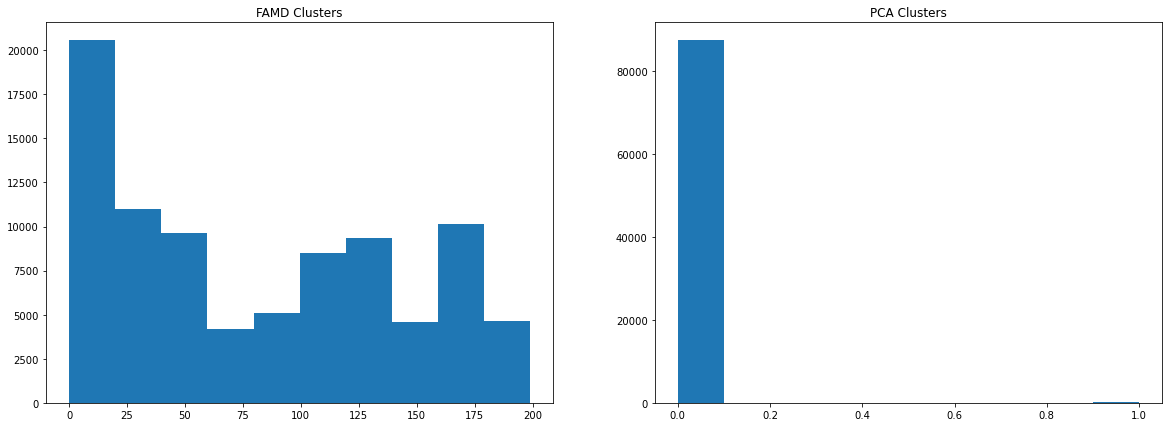

In [80]:
plt.figure(figsize = (20,7)) # wide, tall
plt.subplots_adjust(wspace=0.2)
plt.subplots_adjust(hspace=0.2)

plt.subplot(1,2,1)  # num rows, num col, index
plt.hist(data['FAMDclust'])
plt.title("FAMD Clusters")

plt.subplot(1,2,2)  # num rows, num col, index
plt.hist(data['PCAclust'])
plt.title("PCA Clusters")

plt.show()

In [82]:
#PCA model looks really imbalanced, but hard to tell the numbers exactly, let's look:
print(data['PCAclust'].value_counts())
print()

0    87478
1      210
Name: PCAclust, dtype: int64



I realized at this point that I don't need individual receipt level data, I just need a dataframe with the following columns, without duplicates to predict my results: Vendor Name, Item Description, FAMDclust, and PCAclust. From there I can use a function to return more usable suggestions rather than duplication because of the level of data the original dataframe is showing.

In [203]:
#Creating dataframe with pertinent columns to use for my suggestion function:
pub_item_data = data[['Vendor Name', 'Item Description', 'FAMDclust', 'PCAclust']]
pub_item_data.drop_duplicates(inplace=True)
print(pub_item_data.info())
data.info()
pub_item_data.head(20)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1839 entries, 0 to 87332
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Vendor Name       1839 non-null   object
 1   Item Description  1839 non-null   object
 2   FAMDclust         1839 non-null   int32 
 3   PCAclust          1839 non-null   int32 
dtypes: int32(2), object(2)
memory usage: 57.5+ KB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 87688 entries, 0 to 87746
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   City                87688 non-null  object 
 1   Zip Code            87688 non-null  int32  
 2   County              87688 non-null  object 
 3   Vendor Name         87688 non-null  object 
 4   Item Description    87688 non-null  object 
 5   Pack                87688 non-null  int64  
 6   Bottle Volume (ml)  87688 non-null  int64  
 7   Bottle

,Vendor Name,Item Description,FAMDclust,PCAclust
0,Proximo,Bushmills Irish Whiskey,144,0
1,Pernod Ricard USAAustin Nichols,Jameson Mini,49,0
2,Proximo,Bushmills Irish Whiskey,164,0
3,Gemini Spirits,Concannon,108,0
4,Pernod Ricard USAAustin Nichols,Jameson,86,0
5,Jim Beam Brands,2 Gingers,68,0
6,WILLIAM GRANT AND SONS INC,Tullamore Dew Irish Whisky,89,0
7,Proximo,Bushmills Irish Honey,164,0
8,Pernod Ricard USAAustin Nichols,Jameson,116,0
9,WILLIAM GRANT AND SONS INC,Tullamore Dew Irish Whisky,128,0


## FAMD Cluster Based Suggestions:

In [204]:
#Using the FAMD component based k-means clusters, 
#sampling function for seeing which types of liquor I want to sell at the pub:
def item_recommend_FAMD(Item_Desc, limit):
    cluster_number = pub_item_data.loc[pub_item_data['Item Description']==Item_Desc, 'FAMDclust']
    cluster_df = pub_item_data.loc[pub_item_data['FAMDclust']==cluster_number.values[0]]
    items = cluster_df[['Item Description','Vendor Name','FAMDclust','PCAclust']].sample(n=limit)
    return items

In [205]:
item_recommend_FAMD('Jameson', 10)

,Item Description,Vendor Name,FAMDclust,PCAclust
76,Jameson 12YR HA,Pernod Ricard USAAustin Nichols,86,0
380,Bushmills Irish Whiskey,Proximo,86,0
4733,Jameson 18YR HA,Pernod Ricard USAAustin Nichols,86,0
4205,Paddy Old Irish Whiskey,Pernod Ricard USAAustin Nichols,86,0
2040,Tullamore Dew Irish Whisky,WILLIAM GRANT AND SONS INC,86,0
9273,Paddys Irish Whiskey,Pernod Ricard USAAustin Nichols,86,0
10999,Paddy Bee Sting,Pernod Ricard USAAustin Nichols,86,0
2803,Jameson Caskmates,Pernod Ricard USAAustin Nichols,86,0
1051,Bushmills Irish Honey,Proximo,86,0
4,Jameson,Pernod Ricard USAAustin Nichols,86,0


In [206]:
item_recommend_FAMD('Jameson 12YR HA', 10)

,Item Description,Vendor Name,FAMDclust,PCAclust
79693,Laphroaig 10 Yr Single Malt Scotch,Jim Beam Brands,54,0
791,Bushmills Irish Whiskey,Proximo,54,0
287,Jameson,Pernod Ricard USAAustin Nichols,54,0
374,Bushmills Irish Honey,Proximo,54,0
75941,Aberlour 16yr Scotch,Pernod Ricard USAAustin Nichols,54,0
80955,Tullamore Dew Irish Whisky,William Grant and Sons Inc,54,0
4762,Redbreast 12YR,Pernod Ricard USAAustin Nichols,54,0
32909,Jameson 18YR HA,Pernod Ricard USAAustin Nichols,54,0
27057,Paddy Devils Apple,Pernod Ricard USAAustin Nichols,54,0
444,Jameson Caskmates,Pernod Ricard USAAustin Nichols,54,0


## PCA Cluster Based Suggestions:

In [207]:
#Using the PCA component based k-means clusters, 
#sampling function for seeing which types of liquor I want to sell at the pub:
def item_recommend_PCA(Item_Desc, limit):
    cluster_number = pub_item_data.loc[pub_item_data['Item Description']==Item_Desc, 'PCAclust']
    cluster_df = pub_item_data.loc[pub_item_data['PCAclust']==cluster_number.values[0]]
    items = cluster_df[['Item Description','Vendor Name','FAMDclust','PCAclust']].sample(n=limit)
    return items

In [208]:
item_recommend_PCA('Jameson', 10)

,Item Description,Vendor Name,FAMDclust,PCAclust
29053,Bushmills Black Bush Irish Whiskey,Proximo,23,0
311,Kilbeggan,Jim Beam Brands,120,0
291,Jameson,Pernod Ricard USAAustin Nichols,130,0
78491,Jameson 18YR HA,Pernod Ricard USAAustin Nichols,118,0
1979,Bushmills Irish Honey,Proximo,149,0
1404,2 Gingers,Jim Beam Brands,157,0
113,Jameson 18YR HA,Pernod Ricard USAAustin Nichols,22,0
2688,Jameson 12YR HA,Pernod Ricard USAAustin Nichols,12,0
39334,Midleton Rare HA,Pernod Ricard USAAustin Nichols,37,0
2175,Paddy Old Irish Whiskey,Pernod Ricard USAAustin Nichols,116,0


In [209]:
item_recommend_PCA('Jameson 12YR HA', 10)

,Item Description,Vendor Name,FAMDclust,PCAclust
25169,Jameson 18YR HA,Pernod Ricard USAAustin Nichols,17,0
1195,Bushmills Irish Whiskey,Proximo,69,0
55577,Cedar Ridge Single Malt Whiskey,Cedar Ridge VineyardsLLC,68,0
16973,Bushmills Black Bush Irish Whiskey,Proximo,127,0
4031,Paddy Devils Apple Mini,Pernod Ricard USAAustin Nichols,11,0
186,Jameson,Pernod Ricard USAAustin Nichols,82,0
557,Jameson,Pernod Ricard USAAustin Nichols,155,0
13261,Redbreast 12yr Cask Strength HA,Pernod Ricard USAAustin Nichols,5,0
66433,Paddy Devils Apple Mini,Pernod Ricard USAAustin Nichols,38,0
81688,Laphroaig 10 Yr Single Malt Scotch,Jim Beam Brands,29,0


## Decision

Given that there is such an imbalance on the PCA component based cluster set, I'm going to go with the FAMD component based cluster set. I'm also going to get a smaller subset of suggestions based on an Irish Whiskey that I know I like and a larger one based on larger volume of sales in Iowa:

In [237]:
#Resetting the suggestion function for only pertinent columns:
def item_recommend_FAMD(Item_Desc, limit):
    cluster_number = pub_item_data.loc[pub_item_data['Item Description']==Item_Desc, 'FAMDclust']
    cluster_df = pub_item_data.loc[pub_item_data['FAMDclust']==cluster_number.values[0]]
    items = cluster_df[['Item Description','Vendor Name']].sample(n=limit)
    return items

In [238]:
#Based on an Irish Whiskey I know I like:
preferred = item_recommend_FAMD('Jameson Black Barrel', 5)
preferred

,Item Description,Vendor Name
39,Jameson Black Barrel,Pernod Ricard USAAustin Nichols
3834,Jameson 18YR HA,Pernod Ricard USAAustin Nichols
2079,Bushmills Irish Whiskey,Proximo
75770,Ardbeg 10 Yr Islay Single Malt Scotch,Moet Hennessy USA Inc
1681,Jameson,Pernod Ricard USAAustin Nichols


In [239]:
#Checking out top selling items in Iowa based on sales dollars:
temp = data[['Item Description','Sale (Dollars)']]
temp_sales = temp.groupby(['Item Description']).sum().sort_values(by='Sale (Dollars)', ascending=False)
temp_sales.head(3)

,Sale (Dollars)
Item Description,
Jameson,14096291.35
Bushmills Irish Whiskey,616704.56
Tullamore Dew Irish Whisky,587110.71


In [240]:
#Creating a list of suggestions based on the top three sellers in the state:
sales1 = item_recommend_FAMD('Jameson', 5)
sales2 = item_recommend_FAMD('Bushmills Irish Whiskey', 3)
sales3 = item_recommend_FAMD('Tullamore Dew Irish Whisky', 6)

In [241]:
#Concatenating a list of suggestions to make a single, deduped list of my first items for sale in my pub:
suggestions = pd.concat([preferred,sales1,sales2,sales3])
#pub_items = pd.concat(suggestions)
pub_items=suggestions.drop_duplicates().sort_values(by=['Vendor Name','Item Description'])
pub_items[['Vendor Name','Item Description']].style.hide_index()

Vendor Name,Item Description
Jim Beam Brands,2 Gingers
Jim Beam Brands,Kilbeggan
Moet Hennessy USA Inc,Ardbeg 10 Yr Islay Single Malt Scotch
Pernod Ricard USAAustin Nichols,Jameson
Pernod Ricard USAAustin Nichols,Jameson 12YR HA
Pernod Ricard USAAustin Nichols,Jameson 18YR HA
Pernod Ricard USAAustin Nichols,Jameson Black Barrel
Pernod Ricard USAAustin Nichols,Jameson Mini
Pernod Ricard USAAustin Nichols,Jameson Rarest Vintage Reserve HA
Pernod Ricard USAAustin Nichols,Paddy Bee Sting Mini


# Additional Comments:
There are several different ways I could have approached this question and considerations that I could have taken along the path including but not limited to the below, however this is a valid and relatively easy way to find like items based on past sales within a state in order to start up a proper Irish Pub.

I could have also:
* Run an analysis of the highest selling whiskeys as a time series and predicted what would sell better in the coming months
* Run different dimension reduction methods to find out what might have worked better than the two I chose
* Run different clustering models to see if another clustering model and number of clusters would have worked better
* Focused the analysis on City, County, and/or Zip to hone in on a location for where to put my pub as well as what to stock

# Sláinte!